In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn import decomposition
import os
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [2]:
data = dict()
for name in glob.glob('*.xlsx'):
    data[os.path.basename(name)] = pd.read_excel(name).iloc[1:100, 2:]

In [3]:
features_to_remove = ['хилиум1', 'хилиум2', 'ламели', 'трещины1', 'трещины2', 'потеря креста', 'складки', 'угол']
features_to_onehot = ['форма1', 'форма2', 'поверхность', 'крест', 'луч1', 'луч2']

In [4]:
for key, df in data.items():
    df.drop(columns=features_to_remove, inplace=True)

In [5]:
species = sum([[key]*len(data[key]) for key in data.keys()], [])
data = pd.concat([data[key] for key in data.keys()], axis=0)

### Сейчас species это имена файлов, поэтому нужно убрать из их названий .xlsx, и номер, чтобы название вида было более читабельным

In [6]:
species = list(map(lambda x: x.split('_')[1].split('.')[0], species))

In [7]:
Counter(species)

Counter({'Vicia tetrasperma': 99,
         'Vicia japonica': 99,
         'Vicia amurensis': 99,
         'Vicia hirsuta': 99,
         'Vicia sepium': 99,
         'Vicia villosa': 99,
         'Vicia amoena': 99,
         'Vicia cracca': 99})

In [8]:
mapper = {
    "Клиновидная": "округлая",
    "Бобовидная":  "почкообразная",
    "почковидная": "почкообразная",
    "Вытянутый овал": "овал",
    "Грушевидная": "яйцевидная",
    "грущевидная": "яйцевидная",
    "пэкмэн":  "яйцевидная",
    "ромб": "овал",
    "Неправильная": "неправильная",
    "Сердцевидная": "подтреугольная",
    "треугольная": "подтреугольная",
    "сердцеобразная": "подтреугольная",
    "Двулучевой": "многолучевой",
    "кольцевой": 8,
    "У": "многолучевой"
}

def wave_form(value):
    if str(value).strip().lower().startswith('волн'):
        return 'волнообразная'
    else:
        return value
    
def zigzag_form(value):
    if str(value).strip().lower().startswith('изгиб') or\
    str(value).strip().lower().startswith('изог') or str(value).strip().lower().startswith('извил') or\
     str(value).strip().lower().startswith('дугов'):
        return 'изгибающаяся'
    else:
        return value
    
def u_form(value):
    if str(value).strip().lower().startswith('у'):
        return 'многолучевой'
    else:
        return value

In [9]:
mapper = {k.lower():v for k,v in mapper.items()}

In [10]:
data = data.applymap(lambda x: mapper.get(str(x).lower().strip(), x))
data = data.applymap(zigzag_form)
data = data.applymap(wave_form)
data = data.applymap(u_form)


In [11]:
for feature in features_to_onehot:
    data = pd.concat([data, pd.get_dummies(data.loc[:, feature], prefix=feature)], axis=1)
    data.drop(columns=[feature], inplace=True)

## Фильтрация признаков на основе их количества
Оставим только те признаки, которые представлены хотя бы 5 экземплярами. Можно выбрать и другое число, но часто для использования хи-квадрат критерия в таблицах сопряженности используется такое значение, а поскольку, возможно, этот критерий нужно будет использовать, применим для начала такие условия фильтрации.

In [12]:
leave_features = []
bound = 5
for name, value in data.sum(axis=0).items():
    if value > bound:
        leave_features.append(name)

### Таким образом, мы имеем следующие признаки, которые будут использоваться, чтобы исследоваться видовые различия.

In [13]:
leave_features

['длина',
 'ширина',
 'площадь',
 'форма1_овальная',
 'форма1_округлая',
 'форма2_круг',
 'форма2_неправильная',
 'форма2_овал',
 'форма2_подтреугольная',
 'форма2_полукруг',
 'форма2_почкообразная',
 'форма2_яйцевидная',
 'поверхность_бугристая',
 'поверхность_гладкая',
 'поверхность_складчатая',
 'поверхность_шероховатая',
 'крест_косой',
 'крест_прямой',
 'луч1_волнообразная',
 'луч1_изгибающаяся',
 'луч1_изломанный',
 'луч1_многолучевой',
 'луч1_прямой',
 'луч2_волнообразная',
 'луч2_изгибающаяся',
 'луч2_изломанный',
 'луч2_многолучевой',
 'луч2_прямой']

In [14]:
data = data.loc[:, leave_features]

### Предварительная обработка данных, приведение к единому масштабу

In [15]:
from sklearn.preprocessing import MinMaxScaler



In [16]:
data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns)

### Поиск наиболее дискриминирующих признаков

In [17]:
data.head()

,длина,ширина,площадь,форма1_овальная,форма1_округлая,форма2_круг,форма2_неправильная,форма2_овал,форма2_подтреугольная,форма2_полукруг,...,луч1_волнообразная,луч1_изгибающаяся,луч1_изломанный,луч1_многолучевой,луч1_прямой,луч2_волнообразная,луч2_изгибающаяся,луч2_изломанный,луч2_многолучевой,луч2_прямой
0,0.491660,0.005841,0.245207,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.518784,0.008440,0.333262,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.445079,0.007657,0.254382,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.381255,0.006731,0.212416,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.457677,0.005301,0.207376,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Performing Kruskall-Wallis test for: длина
F_onewayResult(statistic=22.88795120228098, pvalue=2.500940790271689e-28)
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
     Vicia amoena   Vicia amurensis  -0.0478 0.3794 -0.1151  0.0195  False
     Vicia amoena      Vicia cracca   0.0281    0.9 -0.0392  0.0954  False
     Vicia amoena     Vicia hirsuta   0.1007  0.001  0.0334  0.1679   True
     Vicia amoena    Vicia japonica  -0.0247    0.9  -0.092  0.0426  False
     Vicia amoena      Vicia sepium  -0.0061    0.9 -0.0734  0.0612  False
     Vicia amoena Vicia tetrasperma   0.1133  0.001   0.046  0.1806   True
     Vicia amoena     Vicia villosa   0.1603  0.001   0.093  0.2276   True
  Vicia amurensis      Vicia cracca   0.0759 0.0147  0.0086  0.1432   True
  Vicia amurensis     Vicia hirsuta   0.1485  0.001  0.081

C:\Users\ASUS\anaconda3\envs\py37\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


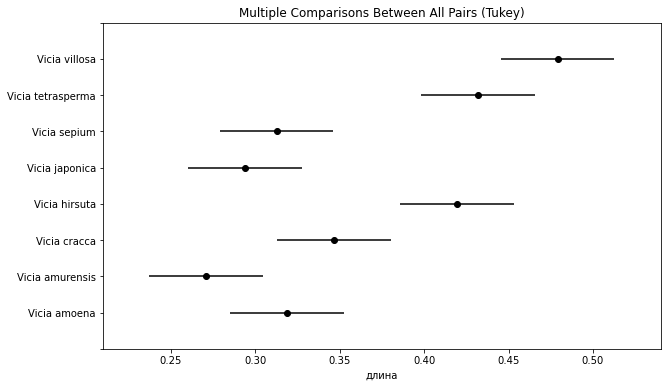

Performing Kruskall-Wallis test for: ширина
F_onewayResult(statistic=0.802349340819298, pvalue=0.5854423432681362)
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
     Vicia amoena   Vicia amurensis   0.0097 0.5345 -0.0057  0.025  False
     Vicia amoena      Vicia cracca   0.0007    0.9 -0.0146  0.016  False
     Vicia amoena     Vicia hirsuta   0.0014    0.9 -0.0139 0.0167  False
     Vicia amoena    Vicia japonica      0.0    0.9 -0.0153 0.0153  False
     Vicia amoena      Vicia sepium   0.0004    0.9 -0.0149 0.0157  False
     Vicia amoena Vicia tetrasperma   0.0018    0.9 -0.0135 0.0172  False
     Vicia amoena     Vicia villosa   0.0015    0.9 -0.0138 0.0168  False
  Vicia amurensis      Vicia cracca  -0.0089 0.6205 -0.0242 0.0064  False
  Vicia amurensis     Vicia hirsuta  -0.0083 0.6961 -0.0236  0.007  Fal

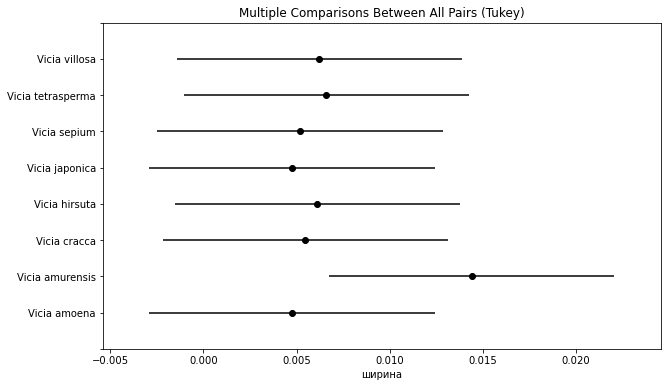

Performing Kruskall-Wallis test for: площадь
F_onewayResult(statistic=15.086488379273787, pvalue=1.444781961635479e-18)
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
     Vicia amoena   Vicia amurensis  -0.0326 0.6156 -0.0882  0.0231  False
     Vicia amoena      Vicia cracca   0.0273  0.786 -0.0283   0.083  False
     Vicia amoena     Vicia hirsuta   0.0644 0.0109  0.0087    0.12   True
     Vicia amoena    Vicia japonica    -0.02    0.9 -0.0756  0.0357  False
     Vicia amoena      Vicia sepium   0.0068    0.9 -0.0488  0.0625  False
     Vicia amoena Vicia tetrasperma   0.0892  0.001  0.0335  0.1448   True
     Vicia amoena     Vicia villosa   0.1018  0.001  0.0462  0.1574   True
  Vicia amurensis      Vicia cracca   0.0599 0.0244  0.0043  0.1155   True
  Vicia amurensis     Vicia hirsuta   0.0969  0.001  0.

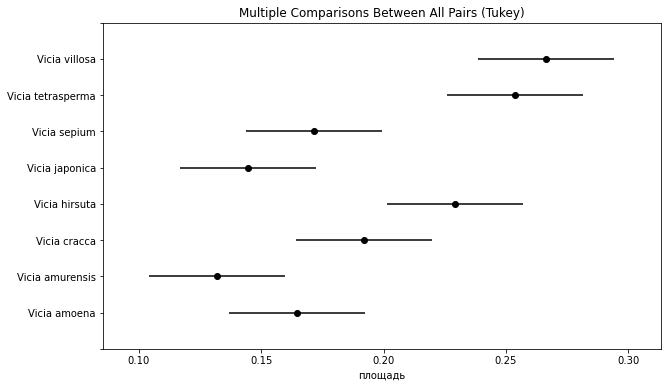

In [18]:
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats as st
mcomp = dict()
grp = data.groupby(species).groups
for feature in leave_features[:3]:
    mcomp[feature] = MultiComparison(data.loc[:,feature].values,species)
    args = [data.loc[v, feature].values for k,v in grp.items()]
    print(f"Performing Kruskall-Wallis test for: {feature}")
    print(st.f_oneway(*args))
    results = mcomp[feature].tukeyhsd()
    results.plot_simultaneous(xlabel=feature)
    print(results.summary())
    plt.show()
    

Выше выполнен однофакторный дисперсионный анализ по количественным признакам -- их всего три здесь, с последующим тестом попарных сравнений Тьюки. 

In [19]:
for feature in leave_features[3:]:
    res = st.chi2_contingency(data.groupby(species)[feature].value_counts().unstack().fillna(0).values)
    if res[1] < 0.05:
        print(f"Гипотеза о независимости признака <{feature}> от вида отвергается. p-val={res[1]} ")

    

Гипотеза о независимости признака <форма1_овальная> от вида отвергается. p-val=9.620484993626093e-15 
Гипотеза о независимости признака <форма1_округлая> от вида отвергается. p-val=9.620484993626093e-15 
Гипотеза о независимости признака <форма2_круг> от вида отвергается. p-val=5.073525792718762e-14 
Гипотеза о независимости признака <форма2_неправильная> от вида отвергается. p-val=7.209286589118994e-08 
Гипотеза о независимости признака <форма2_овал> от вида отвергается. p-val=0.0024397012833148376 
Гипотеза о независимости признака <форма2_полукруг> от вида отвергается. p-val=0.009913283906014222 
Гипотеза о независимости признака <форма2_яйцевидная> от вида отвергается. p-val=2.7361971739675045e-05 
Гипотеза о независимости признака <поверхность_гладкая> от вида отвергается. p-val=8.7881704250228e-30 
Гипотеза о независимости признака <поверхность_складчатая> от вида отвергается. p-val=1.2274530041091592e-17 
Гипотеза о независимости признака <поверхность_шероховатая> от вида отверг

В общем, перечисленные в предыдущей ячейки признаки, у который p-value<0.05 каким-то образом дискриминируют данные виды; точнее, их распределение не соответствует случайному распределению между видами. Возможно, какие-то признаки дискриминируют какие-то два вида, этого достаточно, чтобы тест показал, что "все" виды различимы по признаку.

In [20]:
for feature in leave_features[3:]:
    res = st.chi2_contingency(data.groupby(species)[feature].value_counts().unstack().fillna(0).values)
    if res[1] > 0.05:
        print(f"Гипотеза о независимости признака <{feature}> от вида не отвергается. p-val={res[1]} ")

Гипотеза о независимости признака <форма2_подтреугольная> от вида не отвергается. p-val=0.2015202499008583 
Гипотеза о независимости признака <форма2_почкообразная> от вида не отвергается. p-val=0.7407333611945938 
Гипотеза о независимости признака <поверхность_бугристая> от вида не отвергается. p-val=0.4532966097866392 
Гипотеза о независимости признака <луч1_волнообразная> от вида не отвергается. p-val=0.15370240025698825 
Гипотеза о независимости признака <луч2_волнообразная> от вида не отвергается. p-val=0.2609768272098939 
Гипотеза о независимости признака <луч2_изгибающаяся> от вида не отвергается. p-val=0.18401646868490854 


По этим признакам, у которых p-value >0.05 можно считать, что виды плохо дискриминируются. 

### Исследования всех возможных пар видов и качественных признаков -- наилучим образом их дискриминирующих

In [21]:
num_species = len(np.unique(species))
for feature in leave_features[3:]:
    frame = data.groupby(species)[feature].value_counts().unstack().fillna(0)
    results = []
    for j in range(2, 2**num_species - 1):
        mask = np.array(list(format(j, f'#0{num_species + 2}b')[2:]), dtype=int).astype(bool)
        if mask.sum()==2 and all(frame.loc[mask,:].values.ravel()>5):
            try:
                res = st.chi2_contingency(frame.loc[mask,:].values)
                results.append((frame.index[mask].tolist(), res[0], res[1],frame.loc[mask,:], res[-1]))
            except ValueError:
                pass
    results = sorted(results, key=lambda x: x[1])
    if results:
        print(f"========== {feature} =============")
        for item in results[-1:]:
            print(f"""{item[0]}:
    statistic:={item[1]}
    p-value:={item[2]}
    --------------
    Real-table:=\n{item[3]}
    --------------
    Expected-table:=\n{item[-1]}""")
        print("="*20)

========== форма1_овальная =============
['Vicia amurensis', 'Vicia villosa']:
    statistic:=43.61978136387299
    p-value:=3.987876185282104e-11
    --------------
    Real-table:=
форма1_овальная  0.0  1.0
Vicia amurensis   66   33
Vicia villosa     19   80
    --------------
    Expected-table:=
[[42.5 56.5]
 [42.5 56.5]]
========== форма1_округлая =============
['Vicia amurensis', 'Vicia villosa']:
    statistic:=43.61978136387299
    p-value:=3.987876185282104e-11
    --------------
    Real-table:=
форма1_округлая  0.0  1.0
Vicia amurensis   33   66
Vicia villosa     80   19
    --------------
    Expected-table:=
[[56.5 42.5]
 [56.5 42.5]]
========== форма2_круг =============
['Vicia amurensis', 'Vicia villosa']:
    statistic:=40.27972027972028
    p-value:=2.2008168821289155e-10
    --------------
    Real-table:=
форма2_круг      0.0  1.0
Vicia amurensis   51   48
Vicia villosa     92    7
    --------------
    Expected-table:=
[[71.5 27.5]
 [71.5 27.5]]
========== форма2_н

### Попытка спрогнозировать виды на основе дерева решений

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [23]:
clf = DecisionTreeClassifier(random_state=0, min_samples_split=5)

In [24]:
cross_val_score(clf, data.values, species, cv=3, scoring='accuracy')

array([0.15530303, 0.22727273, 0.15530303])

In [25]:
clf.fit(data.values, species)

DecisionTreeClassifier(min_samples_split=5, random_state=0)

In [26]:
clf.feature_importances_

array([0.23117681, 0.27239732, 0.18036838, 0.01347031, 0.        ,
       0.01242163, 0.01576118, 0.03071863, 0.00615161, 0.01551189,
       0.00286917, 0.02038293, 0.00760915, 0.03721177, 0.        ,
       0.0026725 , 0.00908227, 0.01668286, 0.01442118, 0.02404373,
       0.01831651, 0.        , 0.00662272, 0.        , 0.0139028 ,
       0.02001888, 0.01414189, 0.01404389])

In [27]:
data.columns

Index(['длина', 'ширина', 'площадь', 'форма1_овальная', 'форма1_округлая',
       'форма2_круг', 'форма2_неправильная', 'форма2_овал',
       'форма2_подтреугольная', 'форма2_полукруг', 'форма2_почкообразная',
       'форма2_яйцевидная', 'поверхность_бугристая', 'поверхность_гладкая',
       'поверхность_складчатая', 'поверхность_шероховатая', 'крест_косой',
       'крест_прямой', 'луч1_волнообразная', 'луч1_изгибающаяся',
       'луч1_изломанный', 'луч1_многолучевой', 'луч1_прямой',
       'луч2_волнообразная', 'луч2_изгибающаяся', 'луч2_изломанный',
       'луч2_многолучевой', 'луч2_прямой'],
      dtype='object')

In [28]:
rfk = GradientBoostingClassifier()
clf_results = []
species = np.array(species)
sp_unique = np.unique(species)
for j in range(2, 2 ** num_species - 1):
    mask = np.array(list(format(j, f'#0{num_species + 2}b')[2:]), dtype=int).astype(bool)
    if mask.sum()>=2:
        print(f"{j}: Checking species combination: {sp_unique[mask]}")
        x=cross_val_score(rfk, data.loc[np.isin(species, sp_unique[mask]),:].values, species[np.isin(species, sp_unique[mask])],cv=5, scoring='accuracy').mean()
        clf_results.append((sp_unique[mask], x))



3: Checking species combination: ['Vicia tetrasperma' 'Vicia villosa']
5: Checking species combination: ['Vicia sepium' 'Vicia villosa']
6: Checking species combination: ['Vicia sepium' 'Vicia tetrasperma']
7: Checking species combination: ['Vicia sepium' 'Vicia tetrasperma' 'Vicia villosa']
9: Checking species combination: ['Vicia japonica' 'Vicia villosa']
10: Checking species combination: ['Vicia japonica' 'Vicia tetrasperma']
11: Checking species combination: ['Vicia japonica' 'Vicia tetrasperma' 'Vicia villosa']
12: Checking species combination: ['Vicia japonica' 'Vicia sepium']
13: Checking species combination: ['Vicia japonica' 'Vicia sepium' 'Vicia villosa']
14: Checking species combination: ['Vicia japonica' 'Vicia sepium' 'Vicia tetrasperma']
15: Checking species combination: ['Vicia japonica' 'Vicia sepium' 'Vicia tetrasperma' 'Vicia villosa']
17: Checking species combination: ['Vicia hirsuta' 'Vicia villosa']
18: Checking species combination: ['Vicia hirsuta' 'Vicia tetrasp

97: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia villosa']
98: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia tetrasperma']
99: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia tetrasperma' 'Vicia villosa']
100: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia sepium']
101: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia sepium' 'Vicia villosa']
102: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia sepium' 'Vicia tetrasperma']
103: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia sepium' 'Vicia tetrasperma'
 'Vicia villosa']
104: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia japonica']
105: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia japonica' 'Vicia villosa']
106: Checking species combination: ['Vicia amurensis' 'Vicia cracca' 'Vicia japonica' 'Vicia tetrasperma']
107: Checki

177: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia villosa']
178: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia tetrasperma']
179: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia tetrasperma'
 'Vicia villosa']
180: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia sepium']
181: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia sepium'
 'Vicia villosa']
182: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia sepium'
 'Vicia tetrasperma']
183: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia sepium'
 'Vicia tetrasperma' 'Vicia villosa']
184: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia japonica']
185: Checking species combination: ['Vicia amoena' 'Vicia cracca' 'Vicia hirsuta' 'Vicia japonica'
 'Vicia vill

248: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica']
249: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia villosa']
250: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia tetrasperma']
251: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia tetrasperma' 'Vicia villosa']
252: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia sepium']
253: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia sepium' 'Vicia villosa']
254: Checking species combination: ['Vicia amoena' 'Vicia amurensis' 'Vicia cracca' 'Vicia hirsuta'
 'Vicia japonica' 'Vicia sepium' 'Vicia tetrasperma']


In [35]:
clf_results = sorted(clf_results, key=lambda x: (x[1], len(x[0])))
for res in reversed(clf_results):
    if len(res[0]) == 4:
        print(f"{res[0].tolist()!s:>60}: {res[1]}")

['Vicia amurensis', 'Vicia hirsuta', 'Vicia tetrasperma', 'Vicia villosa']: 0.49477848101265814
['Vicia japonica', 'Vicia sepium', 'Vicia tetrasperma', 'Vicia villosa']: 0.4875
['Vicia amurensis', 'Vicia japonica', 'Vicia tetrasperma', 'Vicia villosa']: 0.47699367088607597
['Vicia amoena', 'Vicia japonica', 'Vicia tetrasperma', 'Vicia villosa']: 0.4723101265822785
['Vicia amurensis', 'Vicia sepium', 'Vicia tetrasperma', 'Vicia villosa']: 0.47227848101265824
['Vicia amoena', 'Vicia hirsuta', 'Vicia japonica', 'Vicia villosa']: 0.46965189873417723
['Vicia hirsuta', 'Vicia japonica', 'Vicia sepium', 'Vicia villosa']: 0.4695253164556962
['Vicia amurensis', 'Vicia cracca', 'Vicia tetrasperma', 'Vicia villosa']: 0.46199367088607596
['Vicia hirsuta', 'Vicia japonica', 'Vicia tetrasperma', 'Vicia villosa']: 0.45696202531645563
['Vicia amurensis', 'Vicia hirsuta', 'Vicia japonica', 'Vicia villosa']: 0.4568037974683544
['Vicia amurensis', 'Vicia hirsuta', 'Vicia sepium', 'Vicia villosa']: 0.4544

### Визуализация с помощью LDA. Все виды.

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [31]:
clf = LinearDiscriminantAnalysis(n_components=2)
X_tr = clf.fit_transform(data.values, species)

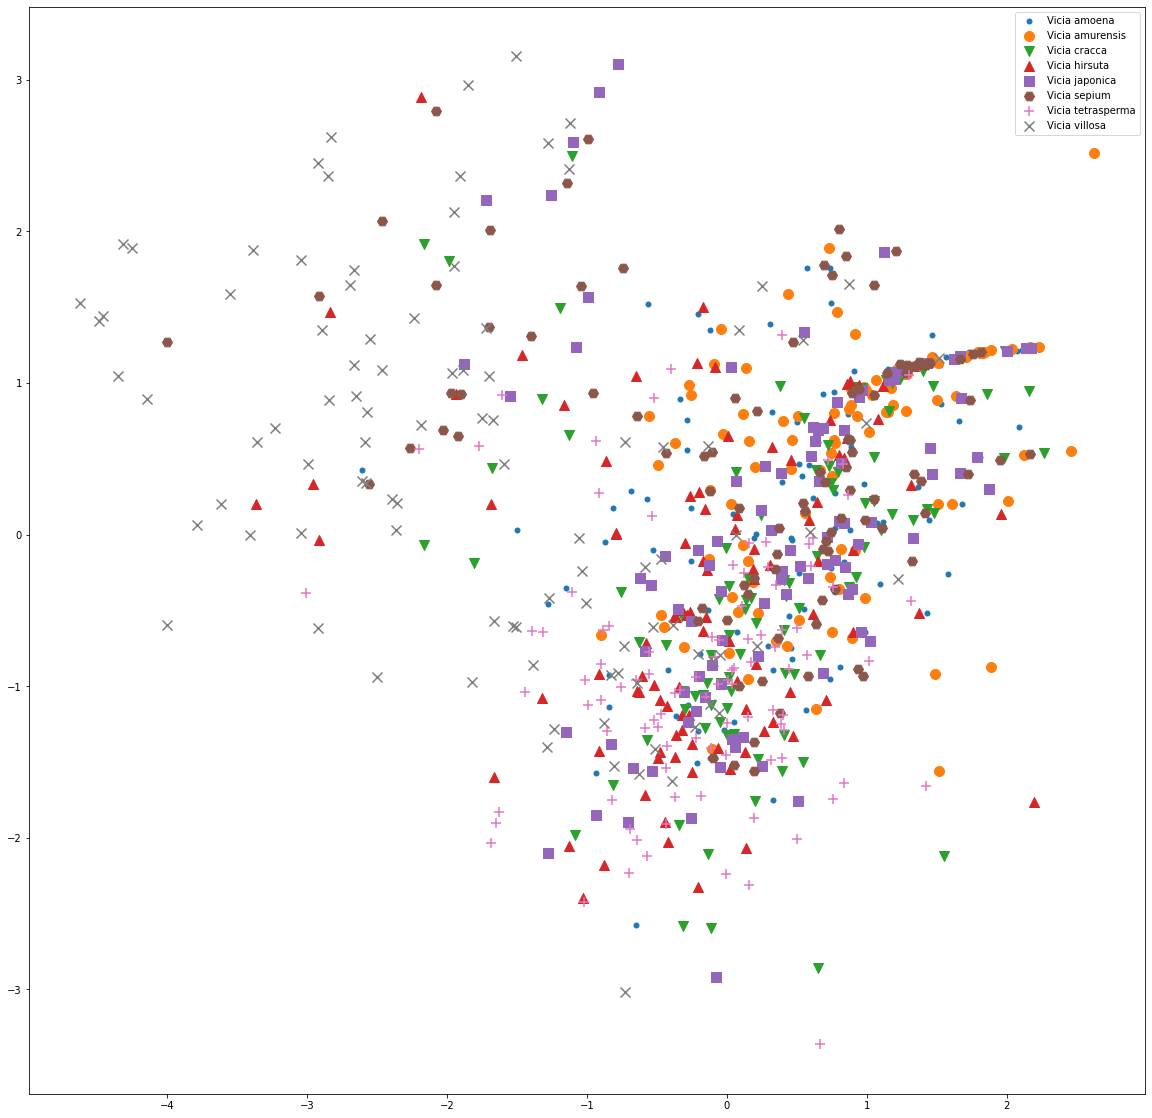

In [32]:
fig = plt.figure(figsize=(20,20))
ax=fig.add_subplot(111)
for sp,m in zip(sp_unique,'.ov^sH+x'):
    ax.scatter(X_tr[species==sp, 0], X_tr[species==sp, 1], marker=m, label=sp, s=100)
plt.legend()